In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
Path= 'Data'
Labels= ['electric car','electric bus']

#getting X and Y
def get_data(file):
    images=[]
    classType= []
    for label in Labels:
        path= Path+'/'+file
        data_path= os.path.join(path,label)
        classnum= Labels.index(label)
        for img in tqdm(os.listdir(data_path)):
            currImg= cv2.imread(data_path+'/'+img)
            Img_rescale= cv2.resize(currImg,(64,64)) #rescale image
            images.append(Img_rescale)
            classType.append(classnum)
    temp= list(zip(images,classType)) #shuffle data
    random.shuffle(temp)
    X,y= zip(*temp)
    X= np.array(X) #convert to array
    y= np.array(y) #convert to array
    y= y.reshape(1,y.shape[0]) #reshape y (from rank 1)
    return X,y

In [3]:
X_train,y_train= get_data('Training_set')
X_test,y_test= get_data('test')

100%|███████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 742.29it/s]


In [4]:
X_train.shape, y_train.shape #check

((1486, 64, 64, 3), (1, 1486))

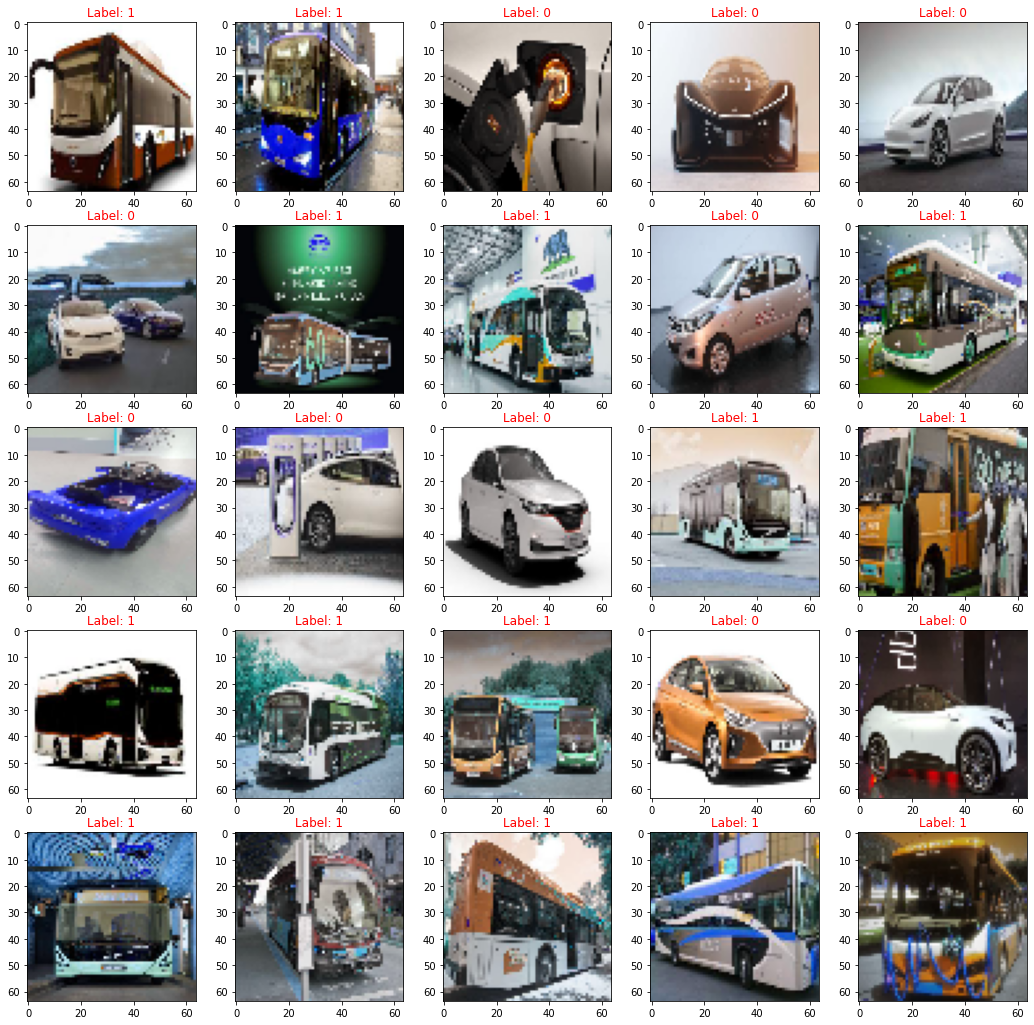

In [5]:
w=10
h=10
fig=plt.figure(figsize=(18, 18))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    r = np.random.randint(X_train.shape[0])
    img = X_train[r].astype('uint8')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'Label: {y_train[0][r]}', c='red')
plt.show()

In [6]:
#preprocess
def preprocess(img):
    img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #grayscale
    img =cv2.equalizeHist(img) #standardize lighting
    img = img/255 #Noramalize values between 0 and 1 
    return img

In [7]:
X_train= np.array(list(map(preprocess,X_train)))
X_test= np.array(list(map(preprocess,X_test)))

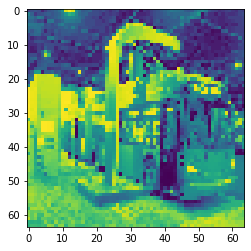

In [8]:
plt.imshow(X_train[np.random.randint(X_train.shape[0])])

In [9]:
#flattening X

X_train= X_train.reshape(X_train.shape[0],-1).T
X_test= X_test.reshape(X_test.shape[0],-1).T

In [10]:
X_train.shape

(4096, 1486)

In [11]:
def init_params(layers):
    np.random.seed(1)
    params= {}
    L= len(layers) #number of layers in the network
    
    for i in range(1,L): #He initialization
        params['W'+str(i)]= np.random.randn(layers[i],layers[i-1])*np.sqrt(2./layers[i-1])
        params['b'+str(i)]= np.zeros((layers[i],1))
    return params

In [12]:
def activation_forward(A_prev,W,b,activation,keep_prob=0.5):
    if activation == 'sigmoid':
        Z= W.dot(A_prev) + b #Z= WX + b
        activation_cache= Z
        A= 1/(1+np.exp(-Z)) #sigmoid function
        D= np.random.randn(A_prev.shape[0],A_prev.shape[1])
        D= (D<keep_prob)
        A_prev= A_prev*D
        A_prev= A_prev/keep_prob
        linear_cache= (A_prev,W,b,D)
    elif activation == 'relu':
        Z= W.dot(A_prev) + b # Z= WX + b
        activation_cache= Z
        A= np.maximum(0,Z) #ReLU function
        D= np.random.randn(A_prev.shape[0],A_prev.shape[1])
        D= (D<keep_prob)
        A_prev= A_prev*D
        A_prev= A_prev/keep_prob
        linear_cache= (A_prev,W,b,D)
    cache= (linear_cache,activation_cache) #tuple ((A,W,b),Z)
    return A,cache

def model_forward(X,params,keep_prob=0.5):
    caches= [] #every cache from activation_forward
    A= X
    L= len(params)//2 #number of layers (2 parameters per layer (W,b))
    for i in range(1,L):
        A_prev= A
        A,cache= activation_forward(
            A_prev,params['W'+str(i)],params['b'+str(i)],activation='relu',keep_prob=0.5) #ReLU on hidden layers
        caches.append(cache)
        
    AL,cache= activation_forward(
        A,params['W'+str(L)],params['b'+str(L)],activation='sigmoid',keep_prob=0.5) #sigmoid on output layer
    caches.append(cache)
    return AL,caches

In [13]:
def cost_func(AL,Y,lambd,params):
    m= Y.shape[1]
    cost= (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y,np.log(1-AL).T)) 
    #L2-regularization
    reg_W= 0
    for i in range(1,len(params)//2):
        reg_W+= np.sum(np.square(params['W'+str(i)])) 
    cost += (lambd/(2*m)) * reg_W
    cost= np.squeeze(cost) 
    return cost

In [14]:
def activation_backward(dA,cache,lambd,keep_prob,activation):
    linear_cache,activation_cache= cache
    Z= activation_cache #unpacking Z 
    A_prev,W,b,D= linear_cache #unpacking A_prev,W,b
    m= A_prev.shape[1]
    if activation == 'relu':
        dZ= np.array(dA,copy=True) #converting dZ to a correct object
        dZ[Z<=0]= 0 #derivative of ReLU
        dW= (1./m) * np.dot(dZ,A_prev.T) + lambd*W/m
        db= (1./m) * np.sum(dZ,axis = 1,keepdims=True) #keepdims=True enables us to retain dims
        dA_prev= np.dot(W.T,dZ)
        dA_prev= dA_prev * D
        dA_prev= dA_prev/keep_prob
    elif activation == 'sigmoid':
        s= 1/(1+np.exp(-Z))
        dZ= dA * s * (1-s) #derivative of sigmoid (dA * s(1-s))
        dW= (1./m) * (np.dot(dZ,A_prev.T)) + lambd*W/m
        db= (1./m) * (np.sum(dZ,axis = 1,keepdims=True)) #keepdims=True enables us to retain dims
        dA_prev= np.dot(W.T,dZ)
        dA_prev= dA_prev * D
        dA_prev= dA_prev/keep_prob
    return dA_prev,dW,db

def model_backward(AL,Y,caches,lambd,keep_prob):
    grads= {}
    L= len(caches) #number of layers
    m= AL.shape[1]
    Y= Y.reshape(AL.shape) #matching the shapes of Y and AL
    
    dAL= -(np.divide(Y,AL) - np.divide(1-Y,1-AL)) #initializing backprop
    #dA,dW,db for Last/Output layer
    current_cache= caches[L-1]
    grads['dA'+str(L-1)],grads['dW'+str(L)],grads['db'+str(L)]= activation_backward(
                                                        dAL,current_cache,lambd,keep_prob,activation='sigmoid')
    
    for i in reversed(range(L-1)):
        current_cache= caches[i]
        dA_prev_temp,dW_temp,db_temp= activation_backward(
                                    grads['dA'+str(i+1)], current_cache,lambd,keep_prob,activation = 'relu')
        grads['dA'+str(i)]= dA_prev_temp
        grads['dW'+str(i+1)]= dW_temp
        grads['db'+str(i+1)]= db_temp
    return grads

In [15]:
def update_params(params,grads,learning_rate):
    L= len(params)//2 #number of layers, 2 params per layer
    for i in range(L):
        params['W'+str(i+1)] = params['W'+str(i+1)] - learning_rate * grads['dW'+str(i+1)]
        params['b'+str(i+1)] = params['b'+str(i+1)] - learning_rate * grads['db'+str(i+1)]
    return params

In [16]:
layers= [4096,10,7,5,1] 

In [17]:
def multi_layer_model(
    X,Y,layers,learning_rate=0.0075,num_iterations=100,lambd=0.7,keep_prob=0.5,print_cost=False):
    np.random.seed(1)
    costs= [] #keep track of cost
    
    params= init_params(layers) #initialize random parameters
    
    for i in range(0,num_iterations): #loop gradient descent
        AL,caches= model_forward(X,params,keep_prob) #forward prop
        cost= cost_func(AL,Y,lambd,params) #compute cost
        grads= model_backward(AL,Y,caches,lambd,keep_prob) #back prop
        params= update_params(params,grads,learning_rate) #update parameters
        
    #print cost after every 10 examples
        if print_cost and i % 100 == 0:
            print (f'Cost after iteration {i}: {cost}')
        if print_cost and i % 100 == 0:
            costs.append(cost)
    return params

In [18]:
parameters= multi_layer_model(
    X_train,y_train,layers,learning_rate=0.009,num_iterations=4000,lambd=0.7,keep_prob=0.85,print_cost=True)

Cost after iteration 0: 0.7088924923732487
Cost after iteration 100: 0.6763020075337727
Cost after iteration 200: 0.598143837323119
Cost after iteration 300: 0.5214065529033783
Cost after iteration 400: 0.4934100446981489
Cost after iteration 500: 0.49766545352857205
Cost after iteration 600: 0.5028917723761038
Cost after iteration 700: 0.4426627210234556
Cost after iteration 800: 0.4276682598743271
Cost after iteration 900: 0.5240528648900208
Cost after iteration 1000: 0.476036869464235
Cost after iteration 1100: 0.4508319263479469
Cost after iteration 1200: 0.4188377548291302
Cost after iteration 1300: 0.3795816529850423
Cost after iteration 1400: 0.45467261870984016
Cost after iteration 1500: 0.36830861137522397
Cost after iteration 1600: 0.4560066112356039
Cost after iteration 1700: 0.30987403925740997
Cost after iteration 1800: 0.32668885931329994
Cost after iteration 1900: 0.30727042927638987
Cost after iteration 2000: 0.3285117869313358
Cost after iteration 2100: 0.2590645763304

In [19]:
def predict(X,y,parameters):
    m = X.shape[1]
    p = np.zeros((1,m))
    
    # A and cache from Forward propagation
    prob, caches = model_forward(X, parameters)
    
    for i in range(0,prob.shape[1]): #for each unit in the output layer
        if prob[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print (f'Accuracy: {str(np.sum((p==y)/m))}')
    return p

In [20]:
prediction_training_set= predict(X_train,y_train,parameters)

Accuracy: 0.993943472409152


In [21]:
prediction_test_set= predict(X_test,y_test,parameters)

Accuracy: 0.8062827225130889
